In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from decimal import *
import math

In [2]:
rawdata_names = """2-FSK 2,4		2-FSK 20		2-FSK 34		GFSK 2,4		GFSK 20		GFSK 34		MSK 2,4		MSK 34		OOK 2,4		OOK 20		OOK 34""".split("\t\t")

rawdata = """
-80	0	-79	0	-79	0	-78,25	0	-79	0	-79	0	-78	0	-77	0	-75	0,02419354839	-79	0	-79	0
-84	0	-80,75	0	-84	0	-83,75	0	-84	0	-81,25	0	-81	0	-81	0	-79,75	0,004032258065	-81,25	0	-81,75	0
-90	0	-85,5	0	-88	0	-87,5	0	-88	0	-85,75	0	-86	0	-85	0	-84,25	0,008064516129	-85,5	0	-86	0
-93	0	-89,75	0	-92	0	-91	0	-92	0	-89,75	0	-90	0,03225806452	-88	0	-90,75	0,04435483871	-89,5	0	-90	0
-97	0	-94,25	0	-97	0	-93,75	0	-97	0	-94,25	0	-94	0,06451612903	-98	0	-94,75	0,03225806452	-93,75	0,2620967742	-94	0,4717741935
-101	0	-100,75	0,6008064516	-100	0,1451612903	-96,5	0	-100	0,1166666667	-99,5	0,5040322581	-100	0,2419354839	-100	0,1612903226	-100	0,9637096774	-101	1	-100	1
-105	0,01612903226	-102,75	0,7137096774	-104,75	0,6129032258	-101	0,2540322581	-105	0,4838709677	-103	1	-106	1	-104	0,4838709677	-105	1	-104	1	-103	1
-107	0,4838709677	-105,25	1	-106	1	-108	1	-107	1	-105	1	-106	1	-108	1	-106	1	-103	1	-102	1
""".replace(',', '.').split()
rawdata = np.array(rawdata, dtype='f8').reshape(-1, 22).transpose()

polyfits = np.empty(11, dtype=object)
for i in range(11):
    for j in range(rawdata[2*i+1].size):
        if rawdata[2*i+1][j-1] == 0 and rawdata[2*i+1][j] > 0 and j != 0:
            last_zero = j-1
    if (i<5 or i==7):
        polyfits[i] = np.polynomial.Polynomial.fit(rawdata[2*i][last_zero:], rawdata[2*i+1][last_zero:], 1).linspace(n=500, domain=[-110, -70])
    if (i==5 or i==6 or i==8):
        polyfits[i] = np.polynomial.Polynomial.fit(rawdata[2*i][last_zero:-1], rawdata[2*i+1][last_zero:-1], 1).linspace(n=500, domain=[-110, -70])
    if (i>8):
        polyfits[i] = np.polynomial.Polynomial.fit(rawdata[2*i][last_zero:-2], rawdata[2*i+1][last_zero:-2], 1).linspace(n=500, domain=[-110, -70])
    #print(rawdata[2*i+1][last_zero:])
    for k in range(polyfits[i][1].size):
        if (polyfits[i][1][k] > 1):
            polyfits[i][1][k] = 1
        elif (polyfits[i][1][k] <= 0):
            polyfits[i][1][k] = 0
    #print(polyfits[i][1])

In [3]:
rawdata_names[-1]

'OOK 34'

In [4]:
markers = "vo<^1P>32p4*"
rawdata_colors="""lightcoral firebrick red peru darkorange gold lawngreen forestgreen midnightblue blue indigo"""
rawdata_colors = rawdata_colors.split(' ')
print(rawdata_colors)
len(markers)

['lightcoral', 'firebrick', 'red', 'peru', 'darkorange', 'gold', 'lawngreen', 'forestgreen', 'midnightblue', 'blue', 'indigo']


12

In [5]:
def np_to_list(x):
    return [float(i) for i in x]

def linearize(array):
    arr = []
    for x in array:
        context = Context(prec=3, rounding=ROUND_UP)
        decimal_part = context.create_decimal_from_float(float(x/10-math.floor(x/10)))
        missing_exp = context.create_decimal_from_float(float(Decimal("10")**decimal_part))
        x = float(Decimal("1e" + str(math.floor(x/10)))*missing_exp)
        arr.append(x)
    return arr

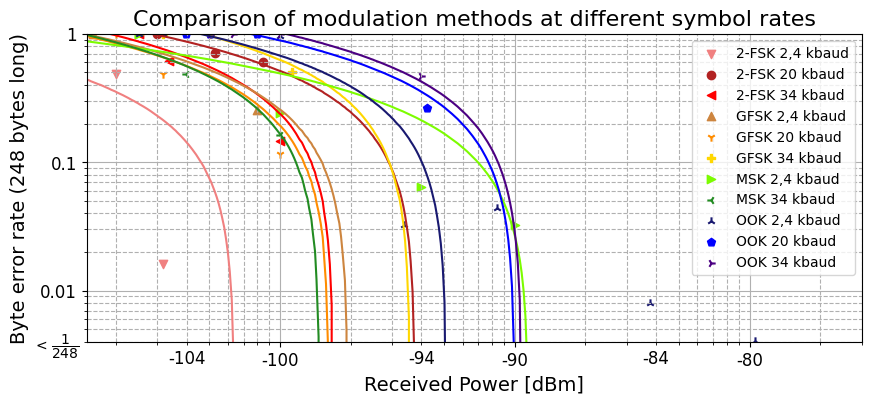

In [6]:
fig, ax = plt.subplots(figsize=(10, 4))
#fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

linealdata = []
linealfit = []

def decibel_fmt(x,pos=None):
    if x==0:
        return "-inf"
    else:
        return '{:.0f}'.format(10*np.log10(np.sign(x)*x))


def decibel_fmt_minor(x,pos=None):
    if x==0:
        return "-inf"
    db_int = round(10*np.log10(np.sign(x)*x))
    db_error = abs(10*np.log10(np.sign(x)*x) - db_int)
    if db_int % 2 == 0 and db_int % 10 != 0 and db_error < 0.05:
        return '{:.0f}'.format(10*np.log10(np.sign(x)*x))

def format_major_p(x, pos=None):
    if (x==1):
        return '{:.0f}'.format(x)
    if (x==0.1):
        return '{:.1f}'.format(x)
    if (x==0.01):
        return '{:.2f}'.format(x)

def minimum_p(x,pos=None):
    if x<=0.0041 and x>=0.0039:
        return r'< $\dfrac{1}{248}$'

for i in range(11):
    linealdata.append(linearize(np_to_list(rawdata[2*i])))
    linealfit.append(linearize(np_to_list(polyfits[i][0])))
    ax.scatter(linealdata[i], rawdata[2*i+1], color=rawdata_colors[i], label=rawdata_names[i] + " kbaud", marker=markers[i])
    ax.plot(linealfit[i], polyfits[i][1], color=rawdata_colors[i])

ax.set_title("Comparison of modulation methods at different symbol rates", fontsize=16)

ax.set_xlabel("Received Power [dBm]", fontsize=14)

ax.set_ylabel("Byte error rate (248 bytes long)", fontsize=14)

ax.tick_params(which='both', axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

ax.minorticks_on()
ax.grid(True, which="minor", axis="y", linestyle="--")
ax.grid(True, which="minor", axis="x", linestyle="--")

ax.set_xscale("log")
ax.set_yscale("log")

ax.xaxis.set_major_formatter(mtick.FuncFormatter(decibel_fmt))
ax.xaxis.set_minor_formatter(mtick.FuncFormatter(decibel_fmt_minor))

ax.yaxis.set_major_formatter(mtick.FuncFormatter(format_major_p))
ax.yaxis.set_minor_formatter(mtick.FuncFormatter(minimum_p))

#ax.set_ylim(-0.05,1.05)

ax.set_ylim(0.004, 1)
ax.set_xlim(1.5e-11, 3e-8)

ax.legend()
ax.grid()
fig.savefig('modulation_comparison.png', dpi=400)
fig.savefig("modulation_comparison.pdf", bbox_inches="tight")